In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
sns.set()
MONTHS = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
J_DAYS = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
CITIES = ['מודיעין מכבים רעות', 'באר שבע', 'נתניה']
MODIIN,BEERSHEVA,NETANIA = CITIES

In [2]:
#full_df = pd.read_pickle('full.pkl')
full_hour_df = pd.read_pickle('hour.pkl')
full_day_df = pd.read_pickle('day.pkl')
id_df = pd.read_pickle('id.pkl')

In [3]:
full_hour_df = full_hour_df[full_hour_df.year == 2022]
full_hour_df.head(1)

,total,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,hour,consumption,ts,temperature,r_humidity,heat_index
0,199.341003,702552276,11,מודיעין מכבים רעות,1,1,5,Saturday,1,52,2022,0,5.037,2022-01-01,10.716666,79.5,10.716667


In [4]:
full_day_df = full_day_df.rename(columns={'total':'consumption'})
full_day_df = full_day_df[(full_day_df.year == 2022) & (full_day_df.city == MODIIN)]
full_day_df.head(1)

,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,consumption,temperature,r_humidity,heat_index,ts
0,702552276,11,מודיעין מכבים רעות,1,1,5,Saturday,1,52,2022,199.341003,9.863194,84.395836,9.863194,2022-01-01


In [5]:
id_df.head(1)

,count_reg,no.,city,city_code_HHI,city_code_LAMAS,street,address,lat,lng
id,,,,,,,,,
702552276,11,32,מודיעין מכבים רעות,1932,1200,חרצית,חרצית 32 מודיעין מכבים רעות,31.905869,35.010933


In [6]:
full_day_df.id.nunique()

2572

## 2572 unique ids in Moddin in 2022

In [7]:
gr = full_day_df[(full_day_df.month >=4) & (full_day_df.month <=9)].groupby('id').count().reset_index()
other_ids = set(full_day_df.id.unique()) - set(gr.id.unique())
not_full_period_ids = set(gr[gr.count_reg < 183].id).union(other_ids)
len(not_full_period_ids)

278

## 278 without daily data in April - September (2294 left)

In [8]:
full_day_df = full_day_df[full_day_df.id.map(lambda x: x not in not_full_period_ids)]
full_day_df.id.nunique()

2294

In [9]:
area_df = pd.read_csv('./raw_data/modiin_join_flr_area.csv')
area_dict = area_df[['building_number', 'flr_area']].set_index('building_number').to_dict()['flr_area']
full_hour_df['area'] = full_hour_df.id.map(lambda x: area_dict.get(x, 0))
full_day_df['area'] = full_day_df.id.map(lambda x: area_dict.get(x, 0))
id_df['area'] = id_df.index.map(lambda x: area_dict.get(x, 0))

In [10]:
no_area_ids = set([x for x in full_day_df.id.unique() if x not in area_dict])
len(no_area_ids)

292

## 292 without area (2002 left)

In [11]:
full_day_df = full_day_df[full_day_df.area > 0]
full_day_df.id.nunique()

2002

In [12]:
full_day_df['consumption_per_sqm'] = full_day_df.consumption / full_day_df.area
full_day_df.head(1)

,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,consumption,temperature,r_humidity,heat_index,ts,area,consumption_per_sqm
0,702552276,11,מודיעין מכבים רעות,1,1,5,Saturday,1,52,2022,199.341003,9.863194,84.395836,9.863194,2022-01-01,12027.25,0.016574


[(-2.0, 0.0)]

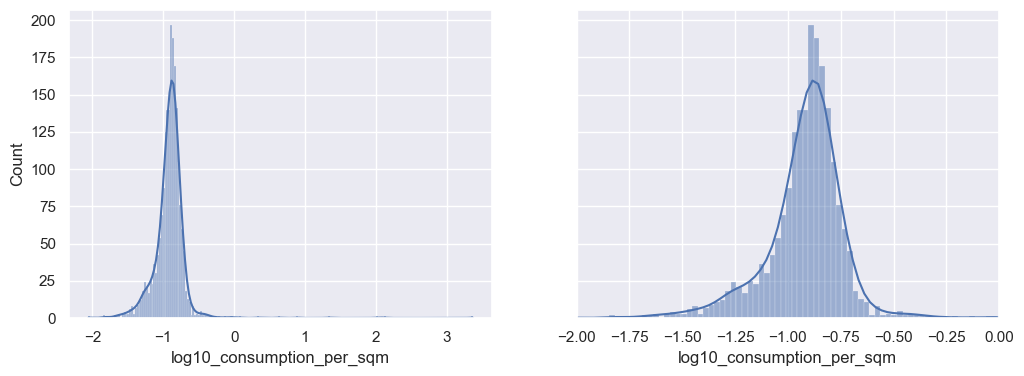

In [13]:
gr = full_day_df.groupby('id').mean(numeric_only=True).reset_index()
gr['log10_consumption_per_sqm'] = np.log10(gr.consumption_per_sqm)
_, ax = plt.subplots(1,2, sharey=True, figsize=(12,4))
sns.histplot(gr.log10_consumption_per_sqm, ax=ax[0], kde=True)
p = sns.histplot(gr.log10_consumption_per_sqm,  ax=ax[1], kde=True)
p.set(xlim=(-2, 0))

In [14]:
overconsuming = gr[gr.log10_consumption_per_sqm > -0.5].id.unique()
underconsuming = gr[gr.log10_consumption_per_sqm < -1.5].id.unique()
overconsuming_one_time = [x for x in full_day_df[full_day_df.consumption_per_sqm > 3].id.unique() if x not in overconsuming]
len(overconsuming), len(underconsuming), len(overconsuming_one_time)

(31, 23, 3)

## 31 overconsuming on avg (> 0.31 per sqm daily on avg)
## 23 underconsuming on avg (< 0.031 per sqm daily on avg)
## 1945 left

In [15]:
full_day_df = full_day_df[full_day_df.id.map(lambda x: x not in overconsuming and x not in underconsuming and x not in overconsuming_one_time)]
full_day_df.id.nunique()

1945

In [17]:
tmp_df = pd.read_csv('./raw_data/buildings_in_stats_areas.csv')
floors_dict = tmp_df[['id', 'floors']].set_index('id').to_dict()['floors']
stat_dict = tmp_df[['id', 'stat_area']].set_index('id').to_dict()['stat_area']
full_hour_df['floors'] = full_hour_df.id.map(lambda x: floors_dict.get(x, 0))
full_day_df['floors'] = full_day_df.id.map(lambda x: floors_dict.get(x,0))
id_df['floors'] = id_df.index.map(lambda x: floors_dict.get(x,0))
full_hour_df['stat_area'] = full_hour_df.id.map(lambda x: stat_dict.get(x, 0))
full_day_df['stat_area'] = full_day_df.id.map(lambda x: stat_dict.get(x,0))
id_df['stat_area'] = id_df.index.map(lambda x: stat_dict.get(x,0))

In [18]:
no_floors_ids = set([x for x in full_day_df.id.unique() if x not in floors_dict])
len(no_floors_ids)

38

# 38 without #floors , 1907 left

In [19]:
full_day_df = full_day_df[full_day_df.floors > 0]
full_day_df.id.nunique()

1907

In [20]:
day_df = pd.DataFrame(full_day_df)
del full_day_df
day_df.head(1)

,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,consumption,temperature,r_humidity,heat_index,ts,area,consumption_per_sqm,floors,stat_area
1301,702552351,9,מודיעין מכבים רעות,1,1,5,Saturday,1,52,2022,165.065994,9.863194,84.395836,9.863194,2022-01-01,1103.75,0.14955,4,113


In [21]:
ids = set(day_df.id.unique())
hour_df = pd.DataFrame(full_hour_df[(full_hour_df.id.map(lambda x: x in ids)) & (full_hour_df.year == 2022)])
del full_hour_df
hour_df['consumption_per_sqm'] = hour_df.consumption / hour_df.area
hour_df.head(1)

,total,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,...,hour,consumption,ts,temperature,r_humidity,heat_index,area,floors,stat_area,consumption_per_sqm
1301,165.065994,702552351,9,מודיעין מכבים רעות,1,1,5,Saturday,1,52,...,0,4.295,2022-01-01,10.716666,79.5,10.716667,1103.75,4,113,0.003891


Text(0.5, 1.0, 'Hourly consumption per sqm')

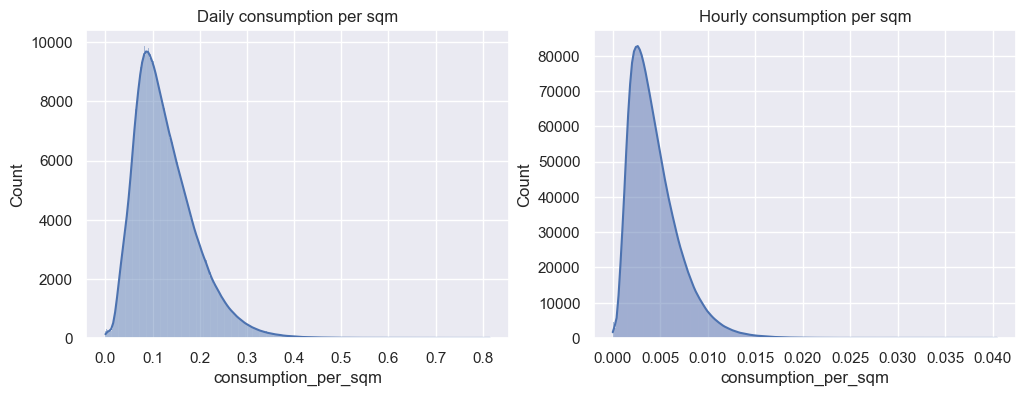

In [ ]:
_, ax = plt.subplots(1,2, figsize=(12,4))
p = sns.histplot(day_df.consumption_per_sqm, ax=ax[0], kde=True)
p.set_title('Daily consumption per sqm')
p = sns.histplot(hour_df.consumption_per_sqm, ax=ax[1], kde=True)
p.set_title('Hourly consumption per sqm')

In [ ]:
hour_df.head(1)

,total,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,...,hour,consumption,ts,temperature,r_humidity,heat_index,area,floors,stat_area,consumption_per_sqm
1301,165.065994,702552351,9,מודיעין מכבים רעות,1,1,5,Saturday,1,52,...,0,4.295,2022-01-01,10.716666,79.5,10.716667,1103.75,4,113,0.003891


# Basic viz

In [ ]:
def radar_plt(stats, ax, title, labels=None):
    if labels is None:
        labels = np.arange(1, len(stats)+1)
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)[::-1] # Set the angle
    stats=np.concatenate((stats,[stats[0]]))  # Closed
    angles=np.concatenate((angles,[angles[0]]))  # Closed
    ax.plot(angles, stats, 'o-', linewidth=2)  # Draw the plot (or the frame on the radar chart)
    ax.fill(angles, stats, alpha=0.25)  #Fulfill the area
    ax.set_thetagrids(angles * 180/np.pi, np.concatenate((labels, labels[:1])))  # Set the label for each axis
    ax.set_title(title)  # Set the pokemon's name as the title
    #ax.set_rlim(0,250)
    ax.grid(True)

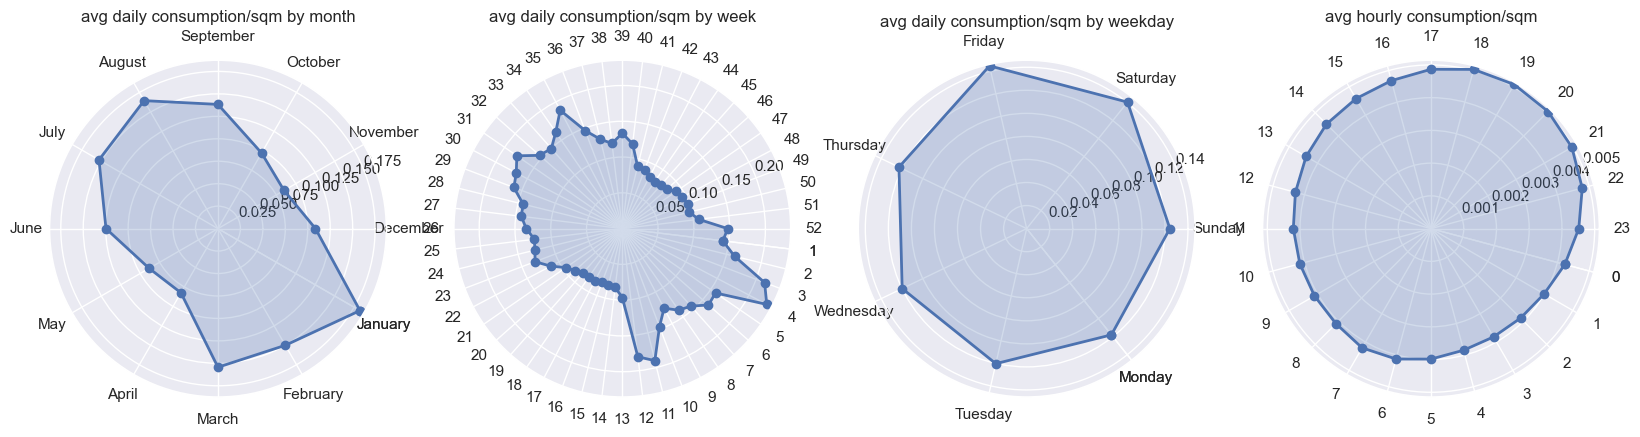

In [ ]:
fig, axs = plt.subplots(figsize=(20, 5), nrows=1, ncols=4,
                            subplot_kw=dict(projection='polar'))
stats=day_df.groupby('month').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[0], 'avg daily consumption/sqm by month', MONTHS)
stats=day_df.groupby('week').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[1], 'avg daily consumption/sqm by week')
stats=day_df.groupby('weekday').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[2], 'avg daily consumption/sqm by weekday', DAYS)
stats=hour_df.groupby('hour').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[3], 'avg hourly consumption/sqm', np.arange(0,24))

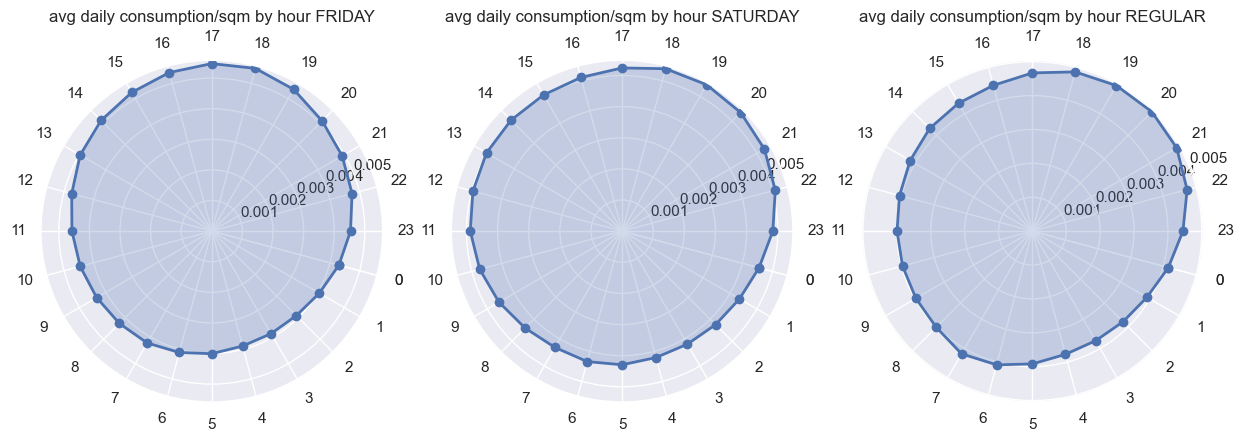

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=3, subplot_kw=dict(projection='polar'))
stats=hour_df[(hour_df.weekday == 4)].groupby('hour').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[0], f'avg daily consumption/sqm by hour FRIDAY', np.arange(0,24))
stats=hour_df[(hour_df.weekday == 5)].groupby('hour').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[1], f'avg daily consumption/sqm by hour SATURDAY', np.arange(0,24))
stats=hour_df[(hour_df.weekday != 4) & (hour_df.weekday != 5)].groupby('hour').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[2], f'avg daily consumption/sqm by hour REGULAR', np.arange(0,24))

[Text(0.5, 1.0, 'consumption_per_sqm during the cold season')]

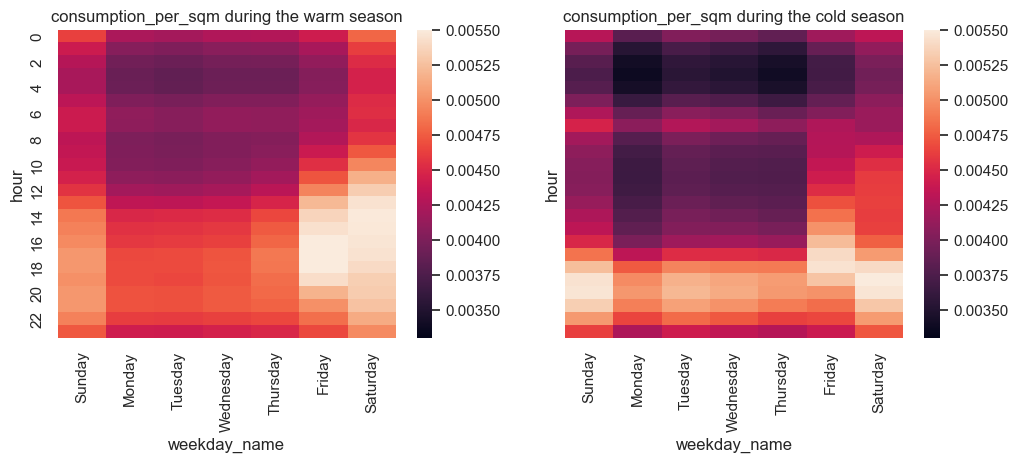

In [ ]:
_, ax = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
table = hour_df[(hour_df.month >=4) & (hour_df.month <= 9)].groupby(['weekday_name', 'hour']).mean(numeric_only=True)['consumption_per_sqm'].reset_index().pivot(columns='weekday_name', index='hour', values='consumption_per_sqm')
p = sns.heatmap(table, ax=ax[0], vmin=0.0033, vmax=0.0055)
p.set(title='consumption_per_sqm during the warm season')
table = hour_df[(hour_df.month <4) | (hour_df.month > 9)].groupby(['weekday_name', 'hour']).mean(numeric_only=True)['consumption_per_sqm'].reset_index().pivot(columns='weekday_name', index='hour', values='consumption_per_sqm')
sns.heatmap(table, ax=ax[1], vmin=0.0033, vmax=0.0055).set(title='consumption_per_sqm during the cold season')

[Text(0.5, 1.0, 'consumption_per_sqm')]

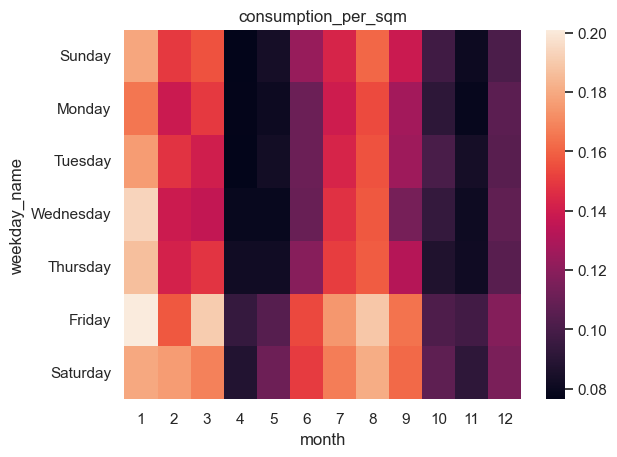

In [ ]:
table = day_df.groupby(['weekday_name', 'month']).mean(numeric_only=True)['consumption_per_sqm'].reset_index().pivot(columns='month', index='weekday_name', values='consumption_per_sqm')
sns.heatmap(table).set(title='consumption_per_sqm')

<Axes: xlabel='floors', ylabel='area'>

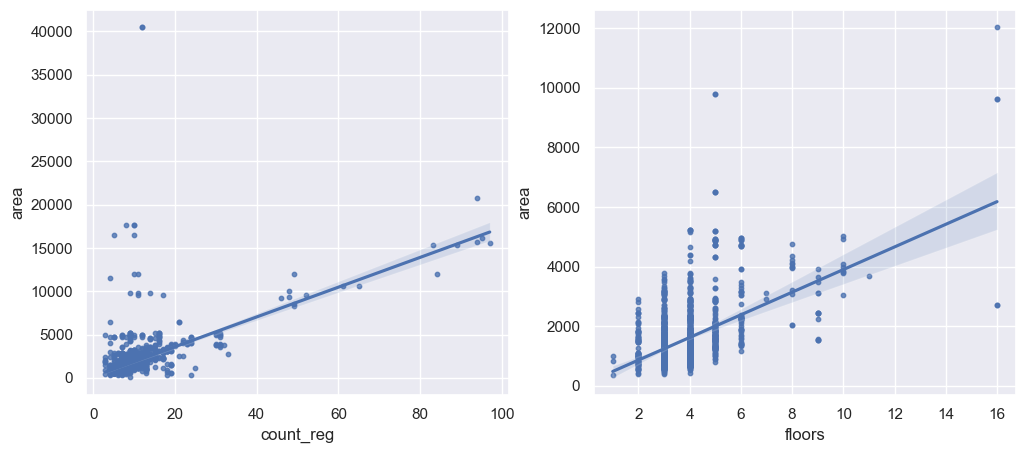

In [29]:
_, ax = plt.subplots(1,2, figsize=(12,5))
sns.regplot(x='count_reg', y='area', data=id_df[id_df.area > 0], scatter_kws={'s':10}, ax=ax[0])
sns.regplot(x='floors', y='area', data=id_df[id_df.floors > 0], scatter_kws={'s':10}, ax=ax[1])

<Axes: xlabel='floors', ylabel='consumption'>

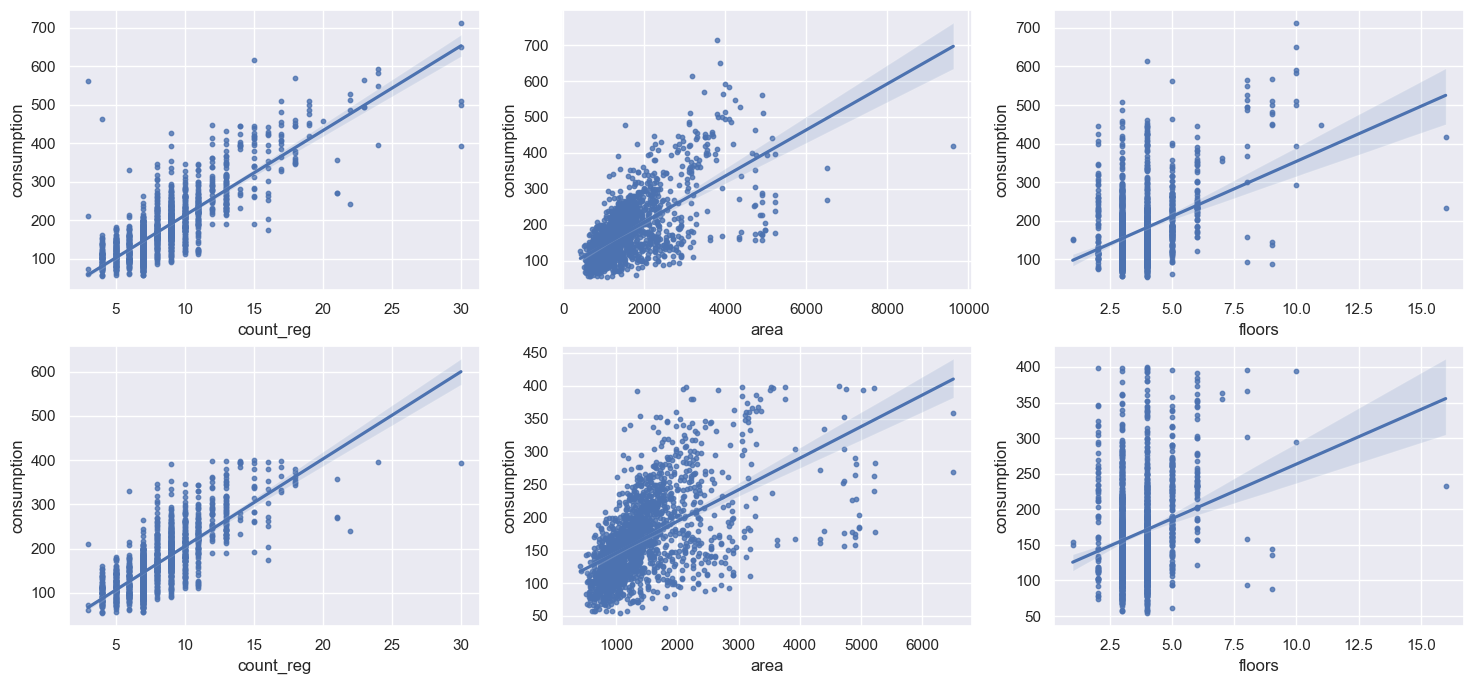

In [30]:
gr = day_df.groupby(['id']).mean(numeric_only=True)
_, ax = plt.subplots(2,3, figsize=(18,8))
sns.regplot(data=gr, x='count_reg', y='consumption', ax=ax[0][0], scatter_kws={'s':10})
sns.regplot(data=gr, x='area', y='consumption',ax=ax[0][1], scatter_kws={'s':10})
sns.regplot(data=gr, x='floors', y='consumption',ax=ax[0][2], scatter_kws={'s':10})
sns.regplot(data=gr[gr.consumption < 400], x='count_reg', y='consumption', ax=ax[1][0], scatter_kws={'s':10})
sns.regplot(data=gr[gr.consumption < 400], x='area', y='consumption',ax=ax[1][1], scatter_kws={'s':10})
sns.regplot(data=gr[gr.consumption < 400], x='floors', y='consumption',ax=ax[1][2], scatter_kws={'s':10})

# Consumption analysis

In [31]:
from collections import defaultdict
h_df = pd.DataFrame(hour_df)
day_mapping = {i: 'regular' for i in range(7)}
day_mapping[4] = 'friday'
day_mapping[5] = 'saturday'
h_df['day_type'] = hour_df.weekday.map(lambda x: day_mapping[x])
h_df.head(1)

,total,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,...,consumption,ts,temperature,r_humidity,heat_index,area,floors,stat_area,consumption_per_sqm,day_type
1301,165.065994,702552351,9,מודיעין מכבים רעות,1,1,5,Saturday,1,52,...,4.295,2022-01-01,10.716666,79.5,10.716667,1103.75,4,113,0.003891,saturday


In [32]:
w_df = pd.read_pickle('weather.pkl').reset_index(drop=True)
w_df = w_df[(w_df.city == MODIIN) & (w_df.ts.dt.year == 2022)]
w_df = w_df.groupby(w_df.ts.dt.day_of_year).mean()
w_df.head(1)

C:\Users\Chapanin\AppData\Local\Temp\ipykernel_19516\3504193848.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  w_df = w_df.groupby(w_df.ts.dt.day_of_year).mean()


,temperature,r_humidity,heat_index
ts,,,
1,9.863194,84.395833,9.863194


In [33]:
%%time
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_
agg_dict = h_df[['id', 'day_type', 'hour', 'consumption_per_sqm']].groupby(['id', 'day_type', 'hour']).agg(
    mean_consumption=('consumption_per_sqm', np.mean), 
    q_consumption=('consumption_per_sqm', percentile(0.2))).to_dict()

results = []
for x in h_df[['id', 'day_type', 'hour', 'consumption_per_sqm']].values:
    row = []
    for name in ['mean_consumption', 'q_consumption']:
        row.append(100*(x[3])/agg_dict[name][x[0], x[1], x[2]])
    results.append(row)
h_df[['normalized_consumption_sqm_day_hour', 'normalized_q_consumption_sqm_day_hour']] = results
h_df.head(1)

CPU times: total: 1min 7s
Wall time: 1min 8s


,total,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,...,temperature,r_humidity,heat_index,area,floors,stat_area,consumption_per_sqm,day_type,normalized_consumption_sqm_day_hour,normalized_q_consumption_sqm_day_hour
1301,165.065994,702552351,9,מודיעין מכבים רעות,1,1,5,Saturday,1,52,...,10.716666,79.5,10.716667,1103.75,4,113,0.003891,saturday,66.453231,134.555144


In [34]:
%%time
agg_dict = h_df[['id','consumption_per_sqm']].groupby(['id']).agg(
    mean_consumption=('consumption_per_sqm', np.mean), 
    q_consumption=('consumption_per_sqm', percentile(0.2))).to_dict()
results = []
for x in h_df[['id', 'consumption_per_sqm']].values:
    row = []
    for name in ['mean_consumption', 'q_consumption']:
        row.append(100*(x[1])/agg_dict[name][x[0]])
    results.append(row)
h_df[['normalized_consumption_sqm', 'normalized_q_consumption_sqm']] = results
h_df.head(1)

CPU times: total: 27 s
Wall time: 27.1 s


,total,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,...,heat_index,area,floors,stat_area,consumption_per_sqm,day_type,normalized_consumption_sqm_day_hour,normalized_q_consumption_sqm_day_hour,normalized_consumption_sqm,normalized_q_consumption_sqm
1301,165.065994,702552351,9,מודיעין מכבים רעות,1,1,5,Saturday,1,52,...,10.716667,1103.75,4,113,0.003891,saturday,66.453231,134.555144,73.253017,147.624948


In [35]:
h_df['r_heat_index'] = np.round(h_df.heat_index).astype('int')
warm_h_df = pd.DataFrame(h_df[(h_df.ts.dt.month >= 4) & (h_df.ts.dt.month <= 9)])

[Text(0.5, 1.0, 'MODIIN regular days April-Sept. Normalized consumption/sqm (w.r.t. 20th quantile for this building/day type/hour)')]

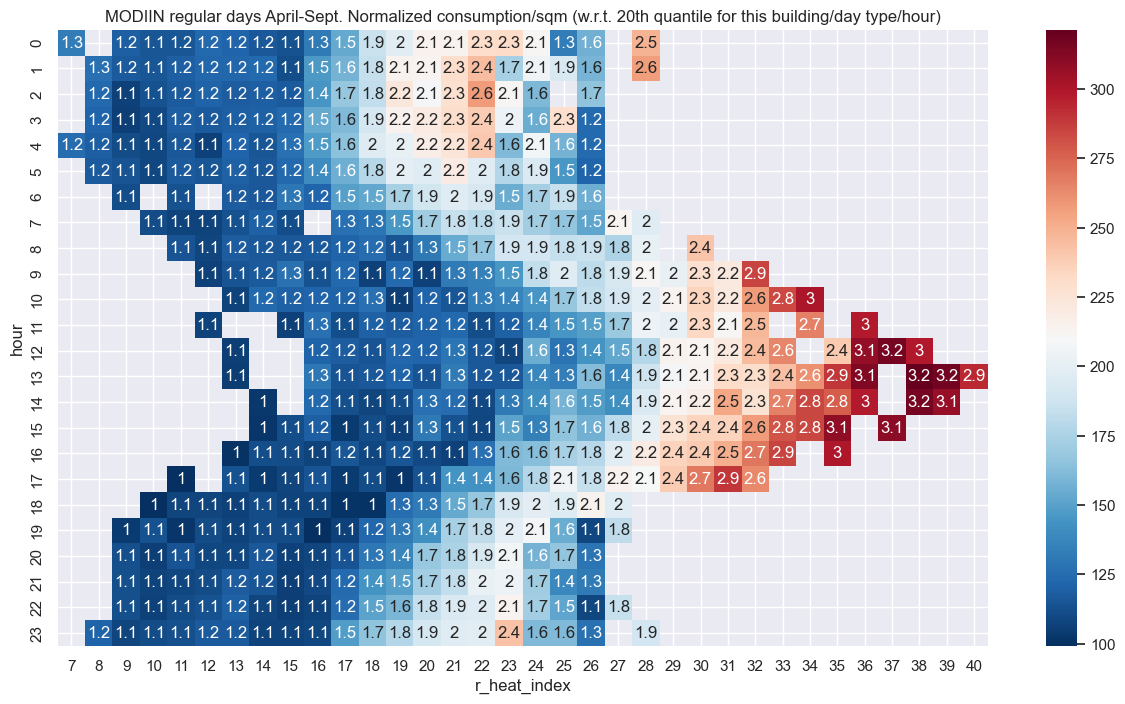

In [36]:
#gr = h_df[['day_type', 'hour', 'consumption', 'temperature', 'n_consumption']].groupby(['day_type', 'hour', 'consumption'
#for day_type in ['regular', 'friday', 'saturday'][:1]:
day_type = 'regular'
tmp = warm_h_df[['hour', 'normalized_q_consumption_sqm_day_hour', 'r_heat_index']]
table = tmp.groupby(['r_heat_index', 'hour']).mean().reset_index().pivot(columns='r_heat_index', index='hour', values='normalized_q_consumption_sqm_day_hour')
plt.figure(figsize=(15,8))
sns.heatmap(table, annot=np.round(table.values/100, 1), cmap='RdBu_r').set(title=f'MODIIN {day_type} days April-Sept. Normalized consumption/sqm (w.r.t. 20th quantile for this building/day type/hour)')

In [37]:
gr = warm_h_df.groupby(['ts', 'day_type', 'hour']).mean().reset_index()
d = w_df.to_dict()['heat_index']
temps = np.array([d[i] for i in range(1,366)])
gr['mean_hi'] = gr.ts.map(lambda x: temps[x.day_of_year - 1])
warm_h_df['mean_hi'] = h_df.ts.map(lambda x: temps[x.day_of_year - 1])
for ws in [3,5,7,10]:
    mean_temps = [temps[0]] + [temps[max(0, i-ws):i].mean() for i in range(1, len(temps))]
    gr[f'{ws}ma_hi'] = gr.ts.map(lambda x: mean_temps[x.day_of_year - 1])
    warm_h_df[f'{ws}ma_hi'] = h_df.ts.map(lambda x: mean_temps[x.day_of_year - 1])

gr.head(1)

C:\Users\Chapanin\AppData\Local\Temp\ipykernel_19516\1989924518.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gr = warm_h_df.groupby(['ts', 'day_type', 'hour']).mean().reset_index()


,ts,day_type,hour,total,id,count_reg,month,day,weekday,day_of_year,...,normalized_consumption_sqm_day_hour,normalized_q_consumption_sqm_day_hour,normalized_consumption_sqm,normalized_q_consumption_sqm,r_heat_index,mean_hi,3ma_hi,5ma_hi,7ma_hi,10ma_hi
0,2022-04-01,friday,0,133.825836,7.025757e+08,8.330886,4.0,1.0,4.0,91.0,...,75.872186,136.90424,74.044403,129.975454,20.0,23.404108,16.324074,14.089222,12.07881,10.191972


<Axes: xlabel='ts', ylabel='heat_index'>

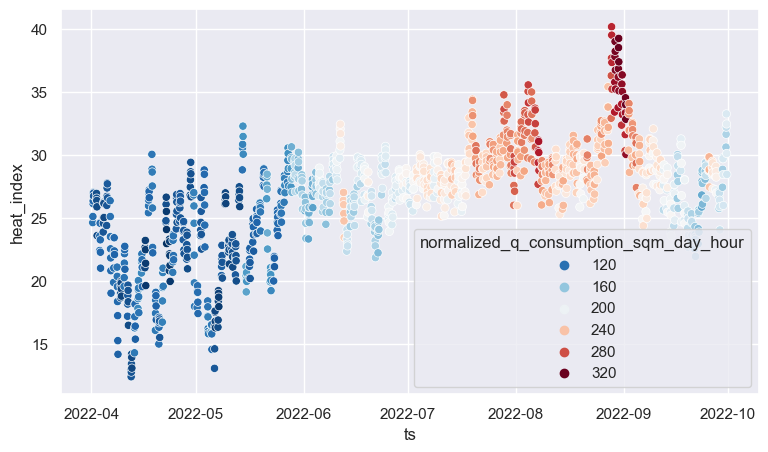

In [38]:
plt.figure(figsize=(9,5))
sns.scatterplot(data=gr[(gr.hour >= 10) & (gr.hour < 17)], x='ts', y='heat_index', hue='normalized_q_consumption_sqm_day_hour', palette='RdBu_r')

<Axes: xlabel='3ma_hi', ylabel='heat_index'>

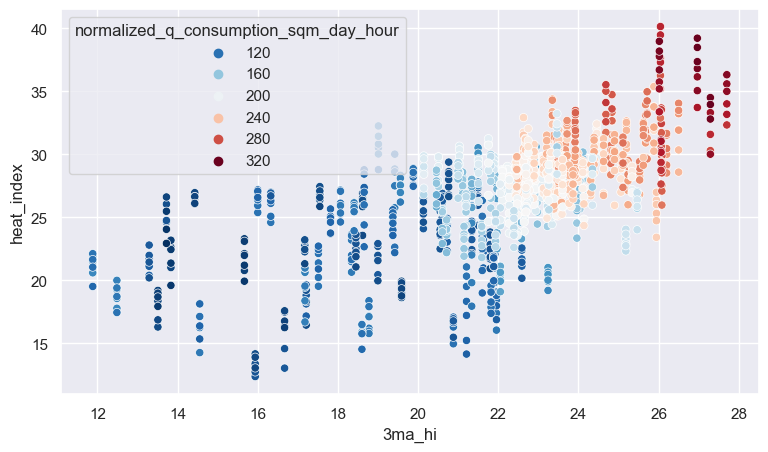

In [39]:
plt.figure(figsize=(9, 5))
sns.scatterplot(data=gr[(gr.hour >= 10) & (gr.hour < 17)], x='3ma_hi', y='heat_index', hue='normalized_q_consumption_sqm_day_hour', palette='RdBu_r')

In [40]:
warm_h_df.columns

Index(['total', 'id', 'count_reg', 'city', 'month', 'day', 'weekday',
       'weekday_name', 'day_of_year', 'week', 'year', 'hour', 'consumption',
       'ts', 'temperature', 'r_humidity', 'heat_index', 'area', 'floors',
       'stat_area', 'consumption_per_sqm', 'day_type',
       'normalized_consumption_sqm_day_hour',
       'normalized_q_consumption_sqm_day_hour', 'normalized_consumption_sqm',
       'normalized_q_consumption_sqm', 'r_heat_index', 'mean_hi', '3ma_hi',
       '5ma_hi', '7ma_hi', '10ma_hi'],
      dtype='object')

In [53]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
CUTOFF = 20
data = warm_h_df[(warm_h_df.hour > 16) & (warm_h_df.hour < 20)][['heat_index', '5ma_hi', '3ma_hi', '7ma_hi', 'normalized_q_consumption_sqm_day_hour', 'normalized_q_consumption_sqm', 'ts', 'area', 'floors', 'stat_area']]
data['shifted_hi'] = np.clip(data.heat_index - CUTOFF, 0, None)
data['shifted_5ma_hi'] = np.clip(data['5ma_hi'] - CUTOFF, 0, None)
data['shifted_3ma_hi'] = np.clip(data['3ma_hi'] - CUTOFF, 0, None)
data['shifted_7ma_hi'] = np.clip(data['7ma_hi'] - CUTOFF, 0, None)
data.head(1)

,heat_index,5ma_hi,3ma_hi,7ma_hi,normalized_q_consumption_sqm_day_hour,normalized_q_consumption_sqm,ts,area,floors,stat_area,shifted_hi,shifted_5ma_hi,shifted_3ma_hi,shifted_7ma_hi
28645827,25.733333,14.089222,16.324074,12.07881,35.336181,52.313192,2022-04-01 17:00:00,1103.75,4,113,5.733333,0.0,0.0,0.0


In [80]:
enc = OneHotEncoder(handle_unknown='ignore')

Feature importances: HEAT_INDEX - 5.49, 7DAY_AVG - 20.68, AREA - 0.0040, FLOORS - 0.74, STAT AREA (MEAN ABS VALUE) - 7.07
R coef: 0.22302193011325122
MSE: 7602.9758996284645


Text(0.5, 1.0, 'Real (red) vs predicted (blue) consumption change between 11 and 16')

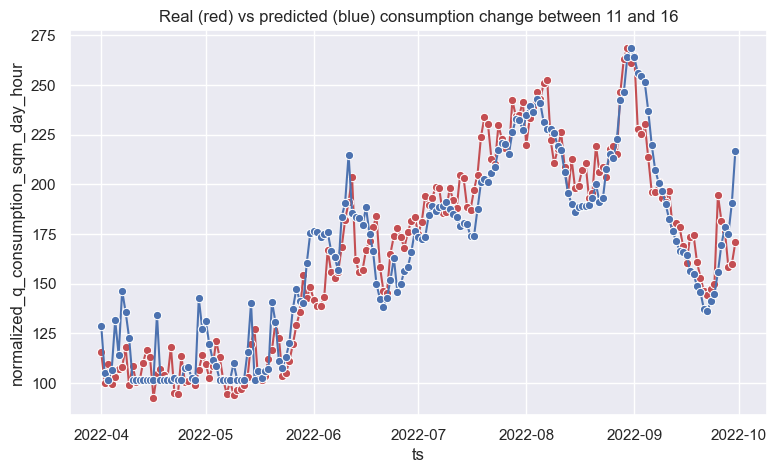

In [94]:
y = data.normalized_q_consumption_sqm_day_hour
X = np.array(data[['shifted_hi', 'shifted_7ma_hi', 'area', 'floors']])
encoded = enc.fit_transform(data[['stat_area']]).todense().A
X = np.concatenate([X,encoded], axis=1)
regr = linear_model.LinearRegression()
regr.fit(X, y)
preds = regr.predict(X)
data['preds'] = preds
print(f'Feature importances: HEAT_INDEX - {regr.coef_[0]:.2f}, 7DAY_AVG - {regr.coef_[1]:.2f}, AREA - {regr.coef_[2]:.4f}, FLOORS - {regr.coef_[3]:.2f}, STAT AREA (MEAN ABS VALUE) - {np.mean(np.abs(regr.coef_)[4:]):.2f}')
print(f'R coef: {regr.score(X, y)}')
print(f'MSE: {mean_squared_error(y, preds)}')
plt.figure(figsize=(9, 5))
gr = data.groupby(data.ts.dt.floor('D')).mean(numeric_only=True).reset_index()
sns.lineplot(data=gr, x='ts', y='normalized_q_consumption_sqm_day_hour', color='r', marker='o')
f = sns.lineplot(data=gr, x='ts', y='preds', color='b', marker='o')
f.set_title('Real (red) vs predicted (blue) consumption change between 11 and 16')

Text(0.5, 1.0, 'Real (red) vs predicted (blue) consumption change between 11 and 16 when trained till 1.08')

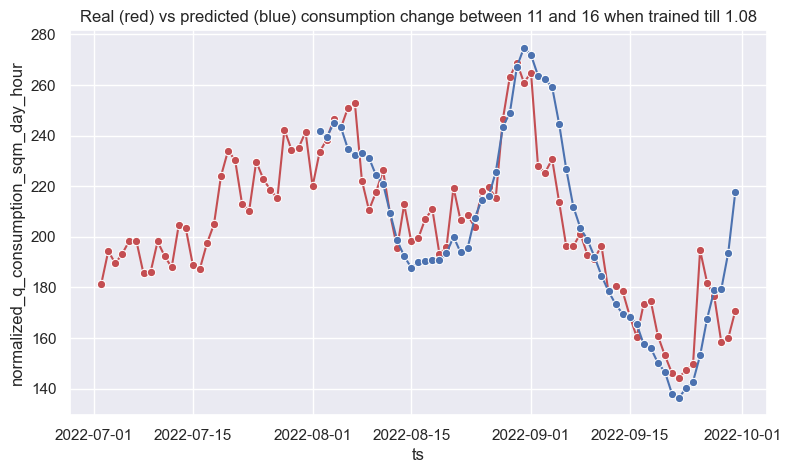

In [92]:
y = data[data.ts < pd.Timestamp('2022-08-01')].normalized_q_consumption_sqm_day_hour
X = np.array(data[data.ts < pd.Timestamp('2022-08-01')][['shifted_hi', 'shifted_7ma_hi', 'area', 'floors']])
encoded_small = enc.fit_transform(data[data.ts < pd.Timestamp('2022-08-01')][['stat_area']]).todense().A
X = np.concatenate([X,encoded_small], axis=1)
regr = linear_model.LinearRegression()
regr.fit(X, y)
data['preds'] = regr.predict(np.concatenate([data[['shifted_hi', 'shifted_7ma_hi', 'area', 'floors']],encoded], axis=1))
plt.figure(figsize=(9, 5))
gr = data.groupby(data.ts.dt.floor('D')).mean(numeric_only=True).reset_index()
sns.lineplot(data=gr[gr.ts > pd.Timestamp('2022-07-01')], x='ts', y='normalized_q_consumption_sqm_day_hour', color='r', marker='o')
f = sns.lineplot(data=gr[gr.ts > pd.Timestamp('2022-08-01')], x='ts', y='preds', color='b', marker='o')
f.set_title('Real (red) vs predicted (blue) consumption change between 11 and 16 when trained till 1.08')

# Or's request

In [46]:
#doi = 240-242 #160-162
#241 161 +-1
day_df.head(1)

,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,consumption,temperature,r_humidity,heat_index,ts,area,consumption_per_sqm
443,702552288,10,מודיעין מכבים רעות,1,1,5,Saturday,1,52,2022,324.125,9.863194,84.395836,9.863194,2022-01-01,12027.25,0.026949


In [66]:
s1 = set(day_df[(day_df.ts.dt.month >= 4) & (day_df.ts.dt.month <= 9)].id.unique())
s2 = set(day_df.id.unique())
s2 - s1

{702553216,
 702553222,
 702553237,
 702553619,
 702568814,
 702583438,
 702583449,
 704184425,
 704190485,
 704193250,
 704194756,
 704196227,
 704198869}

In [69]:
gr = day_df[(day_df.month >=4) & (day_df.month <=9)].groupby('id').count().reset_index()
gr[gr.id == 702553216]

,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,consumption,temperature,r_humidity,heat_index,ts,area,consumption_per_sqm


In [47]:
d_df = pd.DataFrame(day_df[(day_df.ts.dt.month >= 4) & (day_df.ts.dt.month <= 9)])
day_mapping = {i: 'regular' for i in range(7)}
day_mapping[4] = 'friday'
day_mapping[5] = 'saturday'
d_df['day_type'] = d_df.ts.dt.weekday.map(lambda x: day_mapping[x])
d_df.head(1)

,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,consumption,temperature,r_humidity,heat_index,ts,area,consumption_per_sqm,day_type
576,702552288,10,מודיעין מכבים רעות,4,1,4,Friday,91,13,2022,228.871994,23.597916,20.590277,23.404108,2022-04-01,12027.25,0.019029,friday


In [53]:
means = (d_df[['id', 'consumption_per_sqm']].groupby('id').mean()).to_dict()['consumption_per_sqm']

In [54]:
doy = 161
tmp_df = d_df[((d_df.ts.dt.day_of_year < doy-1) | (d_df.ts.dt.day_of_year > doy+1)) & (d_df.day_type == 'regular') & (d_df.month == 6)]
means_june = (tmp_df[['id', 'consumption_per_sqm']].groupby('id').mean()).to_dict()['consumption_per_sqm']

tmp_df = d_df[(d_df.ts.dt.day_of_year >= doy-1) & (d_df.ts.dt.day_of_year <= doy+1)]
means_june_hw = (tmp_df[['id', 'consumption_per_sqm']].groupby('id').mean()).to_dict()['consumption_per_sqm']

In [57]:
doy = 241
tmp_df = d_df[((d_df.ts.dt.day_of_year < doy-1) | (d_df.ts.dt.day_of_year > doy+1)) & (d_df.day_type == 'regular') & (d_df.month == 8)]
means_aug = (tmp_df[['id', 'consumption_per_sqm']].groupby('id').mean()).to_dict()['consumption_per_sqm']

tmp_df = d_df[(d_df.ts.dt.day_of_year >= doy-1) & (d_df.ts.dt.day_of_year <= doy+1)]
means_aug_hw = (tmp_df[['id', 'consumption_per_sqm']].groupby('id').mean()).to_dict()['consumption_per_sqm']

In [58]:
len(means), len(means_june), len(means_june_hw), len(means_aug), len(means_aug_hw)

(1982, 1982, 1982, 1982, 1982)

In [61]:
result_df = day_df[['id', 'city', 'count_reg']].drop_duplicates()
ids = list(result_df.id.unique())
result_df['mean_consumption'] = [means.get(x, np.nan) for x in ids]
result_df['june_week_before'] = [means_june.get(x, np.nan) for x in ids]
result_df['june_heatwave'] = [means_june_hw.get(x, np.nan) for x in ids]
result_df['aug_week_before'] = [means_aug.get(x, np.nan) for x in ids]
result_df['aug_heatwave'] = [means_aug_hw.get(x, np.nan) for x in ids]
result_df = result_df[~result_df.isna().any(axis=1)]
result_df.head(5)

,id,city,count_reg,mean_consumption,june_week_before,june_heatwave,aug_week_before,aug_heatwave
0,702552276,מודיעין מכבים רעות,11,175.972794,148.952408,240.212662,253.524612,331.006683
443,702552288,מודיעין מכבים רעות,10,258.879395,225.950394,312.330688,321.059814,329.205658
1301,702552351,מודיעין מכבים רעות,9,159.139755,165.712006,221.489014,172.667801,253.122681
1731,702552359,מודיעין מכבים רעות,7,161.700516,151.406601,216.144669,178.477386,240.525009
2159,702552363,מודיעין מכבים רעות,7,115.805008,100.506607,158.507675,150.108994,174.927322


In [71]:
import torch
torch.__version__

'2.0.1'

In [62]:
result_df.to_csv('consumption_modiin_netanya_bs.csv')
result_df[result_df.city == BEERSHEVA].to_csv('consumption_bs.csv')

In [63]:
flat_df = result_df.melt(id_vars = ['id', 'city', 'count_reg'], value_name = 'consumption', var_name = 'consumption_type')
flat_df['consumption_per_counter'] = flat_df.consumption / flat_df.count_reg
flat_df.head(1)

,id,city,count_reg,consumption_type,consumption,consumption_per_counter
0,702552276,מודיעין מכבים רעות,11,mean_consumption,175.972794,15.997527


In [67]:
gr = flat_df.groupby('id').max().reset_index()
bad_ids = set(gr[(gr.consumption_per_counter > 70) | (gr.consumption_per_counter < 5)].id.values)
flat_df = flat_df[flat_df.id.map(lambda x: x not in bad_ids)]
result_df = result_df[result_df.id.map(lambda x: x not in bad_ids)]
len(bad_ids)

22

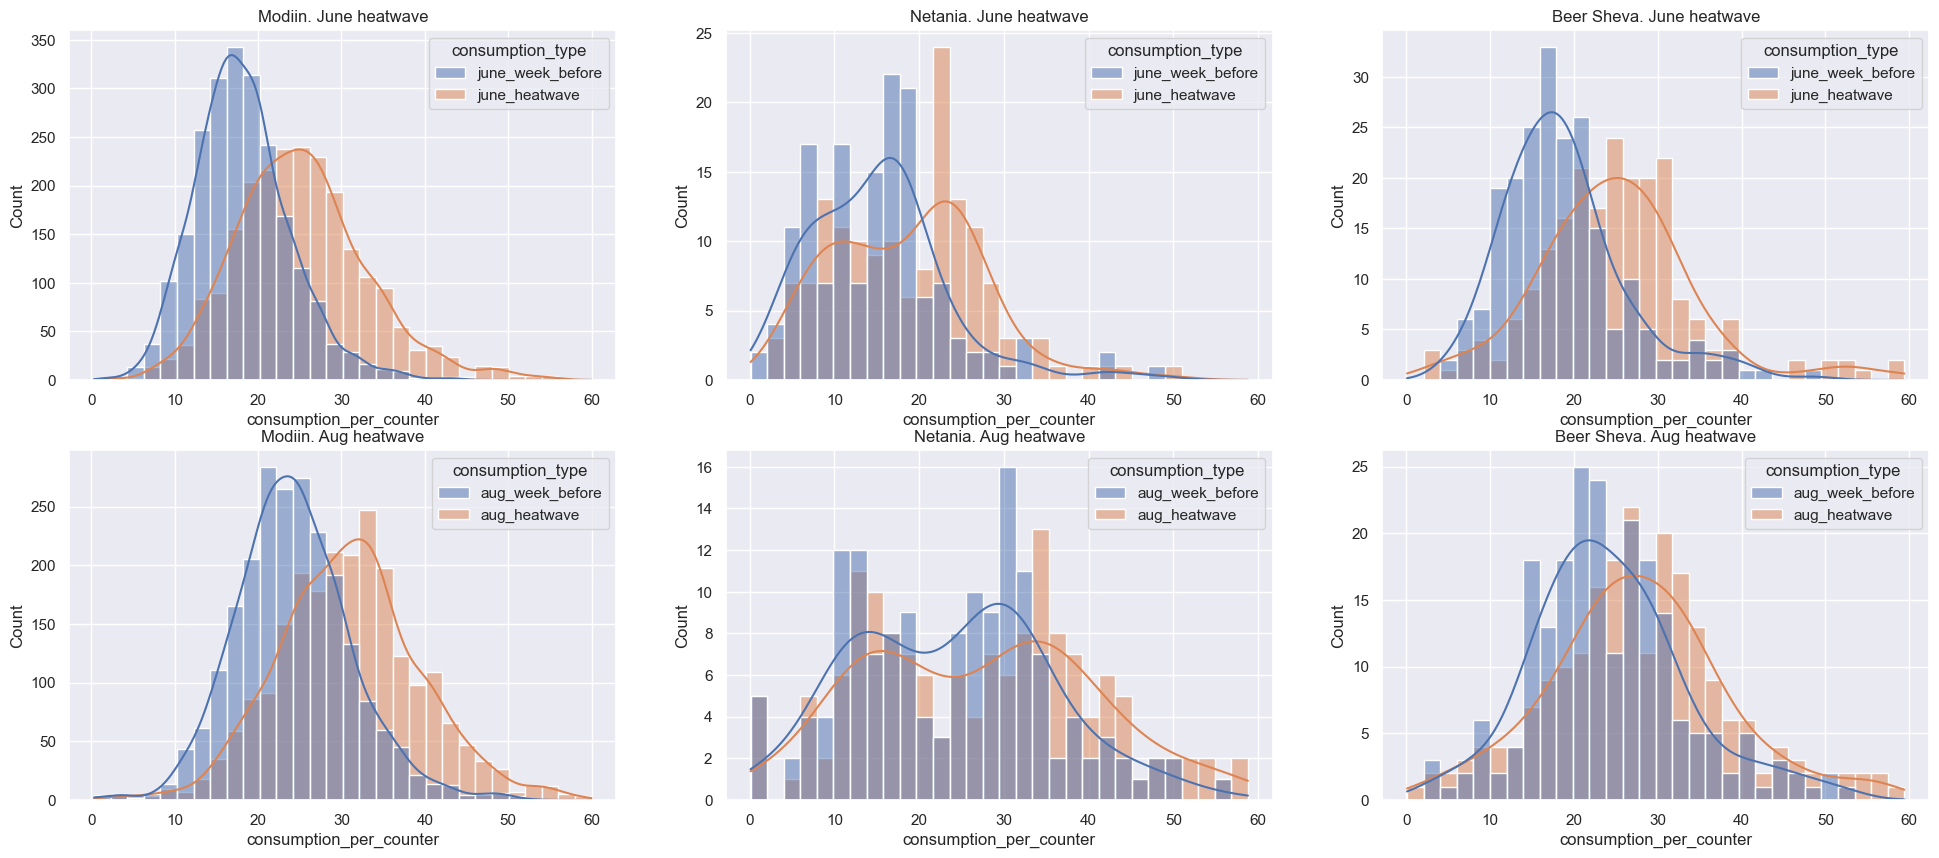

In [30]:
f, ax = plt.subplots(figsize=(24, 10), nrows=2, ncols=3)
f = sns.histplot(data=flat_df[flat_df.city == MODIIN], x='consumption_per_counter', hue='consumption_type', hue_order=['june_week_before', 'june_heatwave'], bins=30, kde=True, ax=ax[0][0])
f.set_title('Modiin. June heatwave')

f = sns.histplot(data=flat_df[flat_df.city == NETANIA], x='consumption_per_counter', hue='consumption_type', hue_order=['june_week_before', 'june_heatwave'], bins=30, kde=True, ax=ax[0][1])
f.set_title('Netania. June heatwave')
f = sns.histplot(data=flat_df[flat_df.city == BEERSHEVA], x='consumption_per_counter', hue='consumption_type', hue_order=['june_week_before', 'june_heatwave'], bins=30, kde=True, ax=ax[0][2])
f.set_title('Beer Sheva. June heatwave')

f = sns.histplot(data=flat_df[flat_df.city == MODIIN], x='consumption_per_counter', hue='consumption_type', hue_order=['aug_week_before', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][0])
f.set_title('Modiin. Aug heatwave')

f = sns.histplot(data=flat_df[flat_df.city == NETANIA], x='consumption_per_counter', hue='consumption_type', hue_order=['aug_week_before', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][1])
f.set_title('Netania. Aug heatwave')
f = sns.histplot(data=flat_df[flat_df.city == BEERSHEVA], x='consumption_per_counter', hue='consumption_type', hue_order=['aug_week_before', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][2])
f.set_title('Beer Sheva. Aug heatwave')

plt.savefig('hw_wrt_week_before')

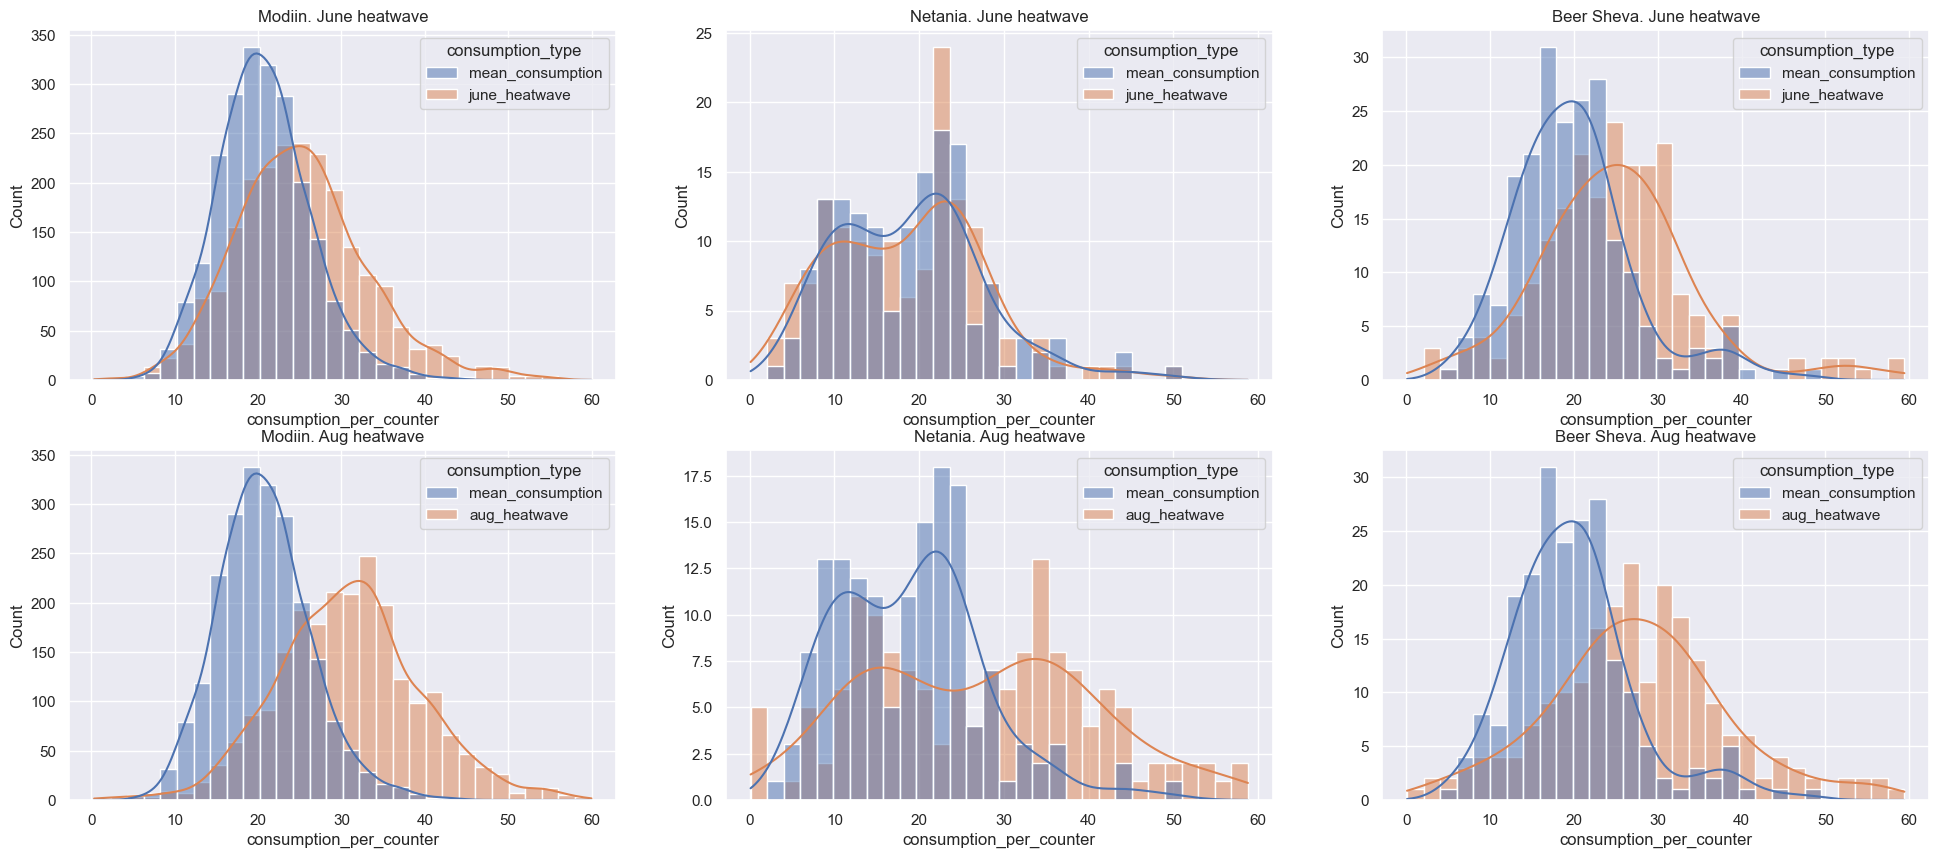

In [31]:
f, ax = plt.subplots(figsize=(24, 10), nrows=2, ncols=3)
f = sns.histplot(data=flat_df[flat_df.city == MODIIN], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'june_heatwave'], bins=30, kde=True, ax=ax[0][0])
f.set_title('Modiin. June heatwave')

f = sns.histplot(data=flat_df[flat_df.city == NETANIA], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'june_heatwave'], bins=30, kde=True, ax=ax[0][1])
f.set_title('Netania. June heatwave')

f = sns.histplot(data=flat_df[flat_df.city == BEERSHEVA], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'june_heatwave'], bins=30, kde=True, ax=ax[0][2])
f.set_title('Beer Sheva. June heatwave')

f = sns.histplot(data=flat_df[flat_df.city == MODIIN], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][0])
f.set_title('Modiin. Aug heatwave')

f = sns.histplot(data=flat_df[flat_df.city == NETANIA], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][1])
f.set_title('Netania. Aug heatwave')
f = sns.histplot(data=flat_df[flat_df.city == BEERSHEVA], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][2])
f.set_title('Beer Sheva. Aug heatwave')

plt.savefig('hw_wrt_avg')